In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler

# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import CSVLogger
# import tensorflow as tf

**Data Loading**

In [2]:
colab_path = '/content/drive/MyDrive/squishy/'
Sampled_train = pd.read_csv("dataset/train.csv")
Sampled_test = pd.read_csv("dataset/test.csv")
Sampled_cv = pd.read_csv('dataset/cv.csv')

In [5]:
Sampled_cv

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,41.0,1,0.24688,3647.9,4533.6,9.4248,26.922,42.385,2704.7,...,53.689,25.002,59.902,22.471,40.327,39.962,44.677,47.324,41.025,19.807
1,0.0,41.0,2,0.25000,3674.5,4529.1,9.2560,27.140,42.360,2705.7,...,53.744,24.695,61.624,22.421,40.185,42.975,48.771,47.409,40.873,17.919
2,0.0,41.0,3,0.24920,3654.1,4508.9,9.1863,26.726,42.283,2704.2,...,53.983,24.782,63.532,22.156,40.091,44.833,48.759,47.478,41.272,19.579
3,0.0,41.0,4,0.25134,3676.3,4554.6,9.3282,26.475,42.852,2702.0,...,53.437,24.571,63.426,21.658,40.113,39.402,46.549,47.418,40.806,16.900
4,0.0,41.0,5,0.25737,3676.2,4446.9,9.2917,27.190,42.568,2703.6,...,52.690,24.805,62.954,22.301,40.527,42.334,47.969,47.395,40.807,19.291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106395,20.0,34.0,496,0.20641,3605.1,4552.1,9.2731,26.630,42.174,2714.3,...,54.617,19.905,62.194,17.119,39.365,40.245,47.838,44.847,41.058,20.687
106396,20.0,34.0,497,0.25420,3616.3,4527.8,9.3712,26.922,42.104,2716.2,...,54.048,24.977,62.279,17.113,39.327,40.658,46.300,44.737,40.980,17.106
106397,20.0,34.0,498,0.25376,3643.9,4538.0,9.2911,27.154,42.133,2718.5,...,53.926,25.020,61.353,17.018,39.062,38.578,43.411,44.541,40.641,20.232
106398,20.0,34.0,499,0.25124,3696.7,4437.7,9.3413,26.936,42.509,2717.5,...,54.437,25.019,61.485,16.412,40.747,40.993,45.869,44.214,41.518,17.912


**Data Preprocessing**

In [17]:
# Drop some mysterious fault type
Sampled_train.drop(Sampled_train[(Sampled_train.faultNumber == 3) | (Sampled_train.faultNumber == 9) | (Sampled_train.faultNumber == 15)].index, inplace = True)
Sampled_test.drop(Sampled_test[(Sampled_test.faultNumber == 3) | (Sampled_test.faultNumber == 9) | (Sampled_test.faultNumber == 15)].index, inplace = True)
Sampled_cv.drop(Sampled_cv[(Sampled_cv.faultNumber == 3) | (Sampled_cv.faultNumber == 9) | (Sampled_cv.faultNumber == 15)].index, inplace = True)

In [18]:
# make the Y value usable in LSTM
y_train = to_categorical(Sampled_train['faultNumber'],num_classes=21)
y_test = to_categorical(Sampled_test['faultNumber'],num_classes=21)
y_cv = to_categorical(Sampled_cv['faultNumber'],num_classes=21)

In [19]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)

In [20]:
# drop unused meta data from x
x_train_df = Sampled_train.drop(['faultNumber','simulationRun','sample'],axis=1)
x_test_df = Sampled_test.drop(['faultNumber','simulationRun','sample'],axis =1)
x_cv_df = Sampled_cv.drop(['faultNumber','simulationRun','sample'],axis =1)

In [21]:
x_test_df

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.25171,3672.4,4466.3,9.5122,27.057,42.473,2705.6,74.750,120.41,0.33642,...,54.494,24.527,59.710,22.357,40.149,40.074,47.955,47.300,42.100,15.345
1,0.25234,3642.2,4568.7,9.4145,26.999,42.586,2705.2,75.126,120.38,0.33801,...,53.269,24.465,60.466,22.413,39.956,36.651,45.038,47.502,40.553,16.063
2,0.24840,3643.1,4507.5,9.2901,26.927,42.278,2703.5,74.540,120.38,0.33702,...,54.000,24.860,60.642,22.199,40.074,41.868,44.553,47.479,41.341,20.452
3,0.25153,3628.3,4519.3,9.3347,26.999,42.330,2703.9,74.861,120.38,0.33648,...,53.860,24.553,61.908,21.981,40.141,40.066,48.048,47.440,40.780,17.123
4,0.21763,3655.8,4571.0,9.3087,26.901,42.402,2707.7,74.380,120.40,0.32114,...,53.307,21.775,61.891,22.412,37.696,38.295,44.678,47.530,41.089,18.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103995,0.26827,3649.8,4499.3,9.3200,26.802,42.250,2699.1,74.217,120.36,0.33150,...,53.919,26.907,62.637,21.743,40.209,39.039,43.465,49.677,40.592,17.575
103996,0.27573,3600.2,4521.3,9.3550,26.812,42.205,2699.8,75.099,120.39,0.35967,...,54.614,26.719,61.912,21.778,42.831,42.310,44.167,49.827,40.957,18.122
103997,0.27337,3598.0,4486.2,9.4248,26.464,42.507,2700.2,75.996,120.38,0.35972,...,55.035,26.951,61.747,21.444,42.824,38.587,43.779,49.802,40.755,16.289
103998,0.23480,3657.4,4515.7,9.3286,26.779,42.215,2703.6,75.501,120.40,0.34155,...,54.206,23.104,62.557,21.862,40.438,41.286,48.560,49.791,41.916,19.503


**Parameters**

In [22]:
cost_false_positive = 2
cost_false_negative = 16

# EVSI rank: xmv_10, xmeas_33, xmv_4, xmeas_25, xmeas_21
#sensors = ['xmv_11', 'xmeas_17', 'xmeas_22', 'xmeas_35', 'xmeas_30']
#model_path = 'models/' + '6_' + 'xmeas_21' + '/'
sensors = ['xmv_10', 'xmv_11', 'xmeas_19', 'xmeas_21', 'xmv_9', 'xmv_4', 'xmv_5', 'xmeas_17', 'xmeas_18', 'xmeas_9']
model_path = 'models/' + '1_' + "none/"
# get prior probability
temp = Sampled_train['faultNumber'].value_counts()
non_fault = temp[0]
total = temp.sum()

temp = Sampled_cv['faultNumber'].value_counts()
non_fault += temp[0]
total += temp.sum()

P_present = non_fault/total
P_absent = 1 - P_present

**Utility Functions**

In [23]:
def feature_remover(features_names):
    # remove a list of features from x
    
    dimension = dict()
    
    # row dimension
    dimension['train_row'] = len(x_train_df)
    dimension['test_row'] = len(x_test_df)
    dimension['cv_row'] = len(x_cv_df)
    
    # create a copy so we don't change the original dataframe
    x_train_masked_df = x_train_df.copy()
    x_test_masked_df = x_test_df.copy()
    x_cv_masked_df = x_cv_df.copy()
    
    for feature in features_names:
        x_train_masked_df.drop([feature], axis = 1, inplace = True)
        x_test_masked_df.drop([feature], axis = 1, inplace = True)
        x_cv_masked_df.drop([feature], axis = 1, inplace = True)
        
    # column dimension
    dimension['train_col'] = x_train_masked_df.shape[1]
    dimension['test_col'] = x_test_masked_df.shape[1]
    dimension['cv_col'] = x_cv_masked_df.shape[1]
    
    standard_scalar = StandardScaler()
    x_train_masked_df = standard_scalar.fit_transform(x_train_masked_df)
    x_test_masked_df = standard_scalar.transform(x_test_masked_df)
    x_cv_masked_df = standard_scalar.transform(x_cv_masked_df)    

    
    x_train = np.resize(x_train_masked_df, (dimension['train_row'], dimension['train_col'], 1))
    x_test = np.resize(x_test_masked_df, (dimension['test_row'], dimension['test_col'], 1))
    x_cv = np.resize(x_cv_masked_df, (dimension['cv_row'], dimension['cv_col'], 1))
    
    return dimension, x_train, x_test, x_cv

In [24]:
# helper function to calculate probability of correctly giving signal when present
def get_signal_present(prediction, ground_truth):
    present_index = list()
    for i in range(len(ground_truth)):
        if ground_truth[i] == 0:
            present_index.append(i)
    
    counter = 0
    for index in present_index:
        if prediction[index] == 0:
            counter += 1
    
    return counter/len(present_index)

# helper function to calculate probability of correctly giving signal when present
# there should be a more generic way using operator module to merge this with the one above.
def get_no_signal_absent(prediction, ground_truth):
    absent_index = list()
    for i in range(len(ground_truth)):
        if ground_truth[i] != 0:
            absent_index.append(i)
    
    counter = 0
    for index in absent_index:
        if prediction[index] != 0:
            counter += 1
    return counter/len(absent_index)

In [25]:
def get_expected_cost(prediction):
  # get P(signal|present) and P(no signal|absent)
    ground_truth = Sampled_test['faultNumber'].tolist()
    P_signal_present = get_signal_present(prediction, ground_truth)
    P_no_signal_absent = get_no_signal_absent(prediction, ground_truth)
    P_signal_absent = 1 - P_no_signal_absent
    P_no_signal_present = 1 - P_signal_present

  # get P(signal)
    P_signal = P_present * P_signal_present + P_absent * P_signal_absent
    P_no_signal = 1 - P_signal

  # bayesian probability
    P_absent_signal = (P_signal_absent * P_absent) / P_signal
    P_present_signal = (P_signal_present * P_present) / P_signal
    P_absent_no_signal = (P_no_signal_absent * P_absent) / P_no_signal
    P_present_no_signal = (P_no_signal_present * P_present) / P_no_signal

  #calculate the evoi
    evoi = P_signal * min(cost_false_positive * P_absent_signal, cost_false_negative * P_present_signal) + P_no_signal * min(cost_false_positive * P_absent_no_signal, cost_false_negative * P_present_no_signal)
  
    return evoi

In [26]:
def plot_dict(dictionary):
    x, y = [], []
    for key, value in dictionary.items():
        x.append(key)
        y.append(value)
    return x, y

**Lower Branch**

In [27]:
# prepare the data
dimension, x_train, x_test, x_cv = feature_remover(features_names = sensors)

In [28]:
# load the model 
base_42_model = load_model(model_path + 'base', compile = False)
base_42_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 42, 256)           264192    
_________________________________________________________________
lstm_29 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_42 (Dense)             (None, 300)               38700     
_________________________________________________________________
dropout_14 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_44 (Dense)             (None, 21)                2709      
Total params: 541,249
Trainable params: 541,249
Non-trainable params: 0
_______________________________________________

In [29]:
# get prediction from the base model
base_prediction = base_42_model.predict_classes(x_test, verbose = 1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
2782/2782 [==============================] - 8s 3ms/step


In [30]:
base_cost = get_expected_cost(base_prediction)
base_cost

1.410942857142857

**Upper Branch**

In [31]:
upper_dict = dict()
for sensor in sensors:
    remove_sensors = sensors.copy()
    remove_sensors.remove(sensor)
    dimension, x_train, x_test, x_cv = feature_remover(features_names = remove_sensors)
    
    upper_model = load_model(model_path + '+' + sensor, compile= False)
    upper_prediction = upper_model.predict_classes(x_test, verbose = 1)
    upper_dict[sensor] = get_expected_cost(upper_prediction)

2782/2782 [==============================] - 8s 3ms/step


In [32]:
upper_dict

{'xmv_10': 0.5809481049562681,
 'xmeas_33': 0.7804454810495626,
 'xmv_4': 0.781392419825073,
 'xmeas_25': 0.8530431486880468,
 'xmeas_21': 0.8312798833819243,
 'xmv_11': 1.1598209912536444,
 'xmeas_17': 0.9060291545189505,
 'xmeas_22': 0.8621860058309039,
 'xmeas_35': 0.8661737609329445,
 'xmeas_30': 0.9216775510204083}

**EVOI**

In [33]:
# Calculate the evoi
evoi_dict = dict()
for sensor in sensors:
    evoi_dict[sensor] = base_cost - upper_dict[sensor]
evoi_dict

{'xmv_10': 0.8299947521865889,
 'xmeas_33': 0.6304973760932945,
 'xmv_4': 0.629550437317784,
 'xmeas_25': 0.5578997084548103,
 'xmeas_21': 0.5796629737609328,
 'xmv_11': 0.2511218658892127,
 'xmeas_17': 0.5049137026239066,
 'xmeas_22': 0.5487568513119532,
 'xmeas_35': 0.5447690962099125,
 'xmeas_30': 0.4892653061224488}

In [34]:
sorted(evoi_dict.items(), key=lambda x: x[1], reverse= True)

[('xmv_10', 0.8299947521865889),
 ('xmeas_33', 0.6304973760932945),
 ('xmv_4', 0.629550437317784),
 ('xmeas_21', 0.5796629737609328),
 ('xmeas_25', 0.5578997084548103),
 ('xmeas_22', 0.5487568513119532),
 ('xmeas_35', 0.5447690962099125),
 ('xmeas_17', 0.5049137026239066),
 ('xmeas_30', 0.4892653061224488),
 ('xmv_11', 0.2511218658892127)]

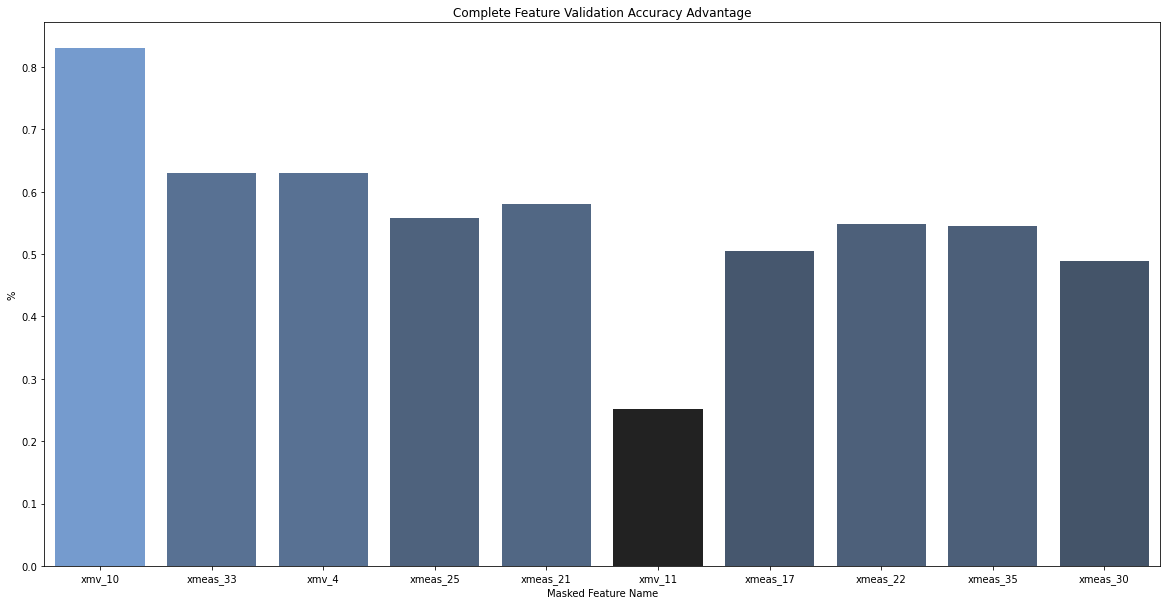

In [35]:
x_1, y_1 = plot_dict(evoi_dict)
#y_1_100 = [z * 100 for z in y_1]
plt.figure(figsize=(20,10))
sns.barplot(x_1, y_1, palette = mpl.cm.ScalarMappable(cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True)).to_rgba(y_1))
#plt.xticks(rotation=45);
#plt.ylim((-5.0, 16.0))
plt.title('Complete Feature Validation Accuracy Advantage')
plt.ylabel('%')
plt.xlabel('Masked Feature Name');